In [152]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

In [153]:
data = pd.HDFStore('data/data.h5','r')
parammat=data['parammat']
targ=data['targ']
data.close()

In [154]:
from sklearn.model_selection import train_test_split
XTraining, XValidation, YTraining, YValidation = train_test_split(parammat,targ,test_size=0.1, shuffle=False) # before model building

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print(tf.config.list_physical_devices())

2.16.1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [155]:
fflds=targ.columns.get_level_values(0)
fdates=targ.columns.get_level_values(1)
flds=targ.columns.get_level_values(0).unique()
dates=targ.columns.get_level_values(1).unique()
nflds=targ.shape[1]
nflds

20

In [156]:
dnn_model=keras.models.load_model('data/dnn_cicero.keras')

/Users/sanderson/Documents/GitHub/ciceroscm/venv/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adamw', because it has 14 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [157]:
X_train = tf.convert_to_tensor(XTraining, dtype=tf.float32)
Y_train = tf.convert_to_tensor(YTraining, dtype=tf.float32)
X_dev = tf.convert_to_tensor(XValidation, dtype=tf.float32)
Y_dev = tf.convert_to_tensor(YValidation, dtype=tf.float32)

In [158]:
pred = dnn_model.predict(X_dev)
pred_t = dnn_model.predict(X_train)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


In [159]:
store = pd.HDFStore('data/obs.h5','r')
obs=store['obs']
obsunc=store['obsunc']
store.close()

In [160]:
np.where(targ.std()!=0)

(array([ 0,  1,  2,  3,  4,  5,  6,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19]),)

In [161]:
use=np.where(((np.isnan(obs)==False).to_numpy())&((targ.std()!=0).to_numpy()))

In [177]:
obsunc.loc['concentrations-CO2']=1
obsunc.loc['OHC700']=20



In [198]:
def skillscore(targ,obs,obsunc,use):
  errm=(((obs.to_numpy()-targ)/obsunc.to_numpy())**2)
  out=-np.sum((errm[:,use[0]]),axis=1)
  return out

In [207]:
skl=skillscore(YTraining.to_numpy(),obs,obsunc,use)

In [290]:
bst=skl.argsort()[-1000:]

In [291]:
bst.shape

(1000,)

/var/folders/84/4wyjr_hn4z3_63hhr5k4mf6m0000gn/T/ipykernel_4820/1169666206.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ax[i].axhline(obs[i],color='r')


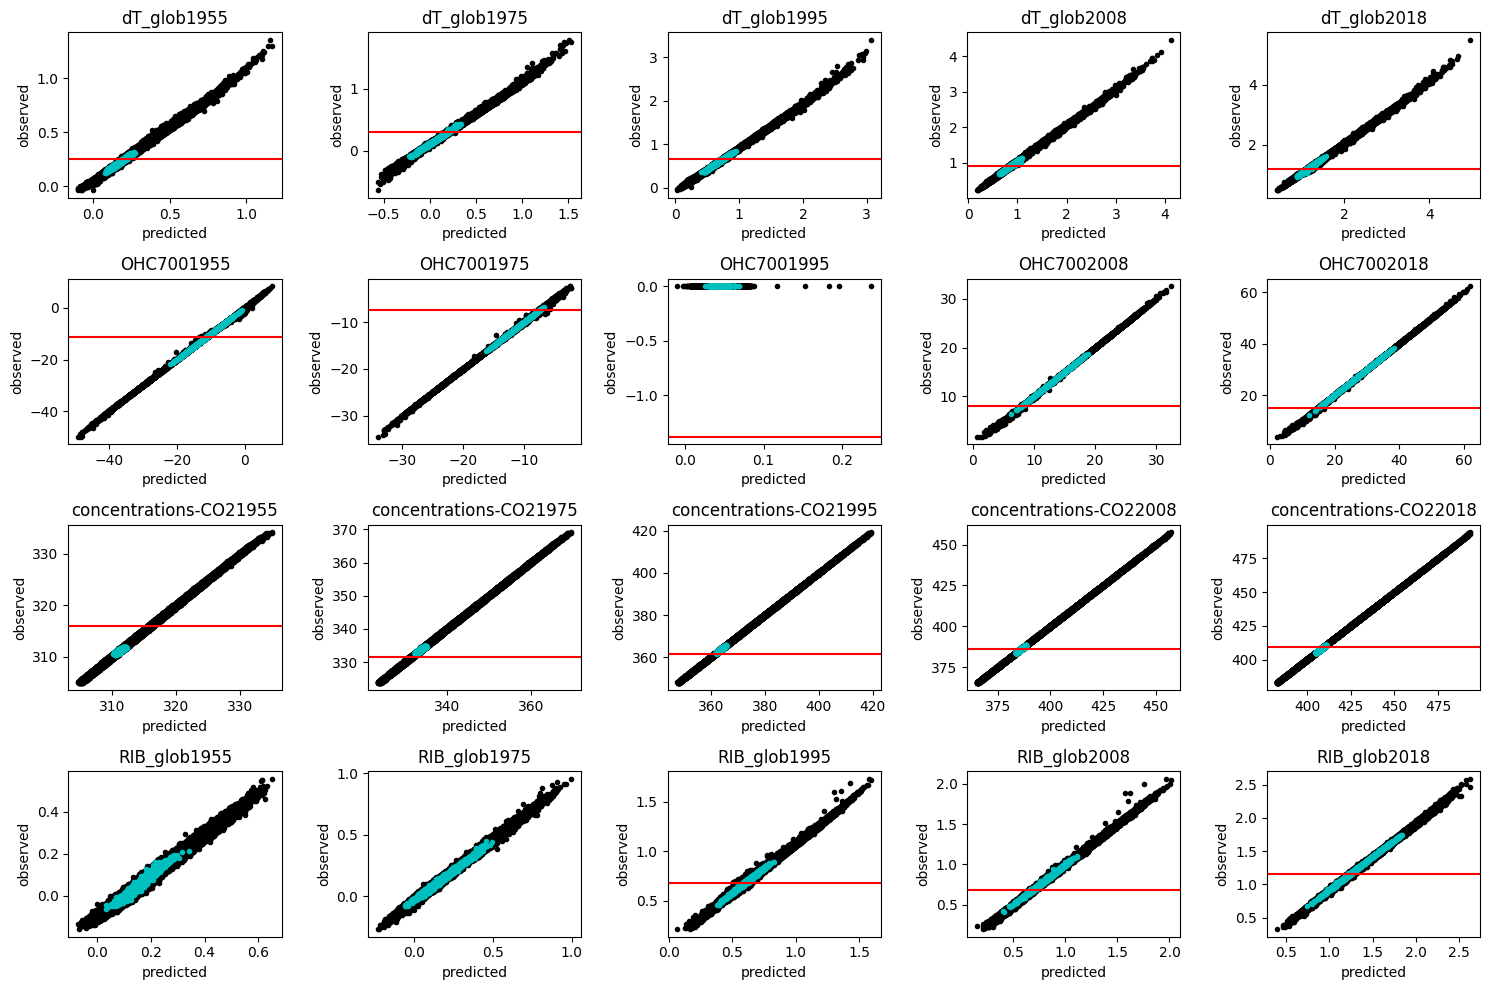

In [292]:
fig, ax = plt.subplots( len(flds), len(dates),figsize=(15, 10))

ax=ax.flatten()
for i in np.arange(nflds):
  ax[i].plot(pred_t[:,i],Y_train[:,i],'.k')
  ax[i].plot(pred_t[bst,i],Y_train.__array__()[bst,i],'.c')
  #ax[i].plot(pred[:,i],Y_dev[:,i],'r.')
  ax[i].set_title(fflds[i]+str(fdates[i]))
  ax[i].set_xlabel('predicted')
  ax[i].set_ylabel('observed')
  ax[i].axhline(obs[i],color='r')
plt.tight_layout()

In [309]:
pmin=XTraining.min()
pmax=XTraining.max()

rlamdo           23.437378
akapa             0.334014
cpi               0.166335
W                 0.938651
beto              0.735553
lambda            2.001113
mixed            31.921375
qdirso2          -0.305921
qindso2          -0.868275
qbc               0.194447
qoc              -0.081758
beta_f            0.305098
mixed_carbon    120.173169
qh2o_ch4          0.087677
Name: 0, dtype: float64

In [371]:
def log_prob(p,obs,obsunc,use,pmin,pmax):
    if type(p)!=pd.core.frame.DataFrame:
      p=pd.DataFrame(p)
    if len(p.shape)==1:
      p=p[np.newaxis,:]
    pred=dnn_model.predict(p,verbose = 0)
    out=skillscore(pred,obs,obsunc,use).T
    out[np.isnan(out)]=-5e5
    out[np.abs(out)>5e5]=-5e5
    inrange=(np.vstack([p.iloc[:,i].between(pmin.iloc[i],pmax.iloc[i]).to_numpy() for i in np.arange(ndim)]).sum(axis=0)!=ndim)*1e10
    out=out-inrange
    return out

True

In [372]:
predskl=log_prob(XTraining,obs,obsunc,use,pmin,pmax)

In [370]:
predskl

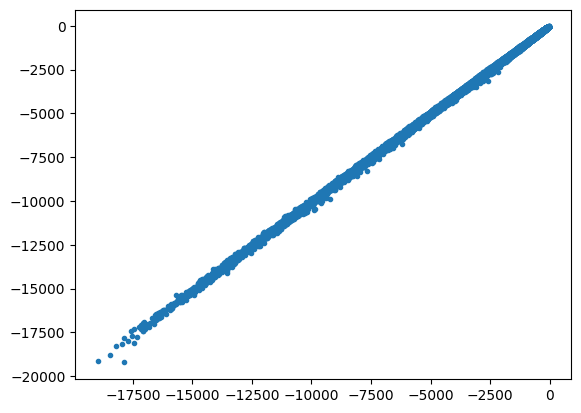

In [373]:
plt.plot(predskl,skl,'.')

In [222]:
import emcee


In [284]:
ndim=parammat.shape[1]


In [374]:


 nwalkers = len(bst)
ivar = 1. / np.random.rand(ndim)
p0 = X_train.__array__()[bst,:]

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=[obs,obsunc,use,pmin,pmax],vectorize=True)
sampler.run_mcmc(p0, 2000,progress=True)

100%|██████████| 2000/2000 [30:08<00:00,  1.11it/s]    


State([[1.6134249e+01 4.5909250e-01 3.7354904e-01 ... 3.5387227e-01
  8.2710098e+01 8.2246393e-02]
 [6.0275383e+00 5.9535760e-01 4.8790431e-01 ... 4.2058191e-01
  7.4186882e+01 9.6502170e-02]
 [1.4533054e+01 7.9559058e-01 4.7506422e-01 ... 2.6306254e-01
  9.6901421e+01 8.3235174e-02]
 ...
 [1.7236712e+01 5.3202242e-01 3.6511916e-01 ... 4.2589450e-01
  7.0861992e+01 9.9150851e-02]
 [1.2987338e+01 3.8317877e-01 4.0525076e-01 ... 2.4961673e-01
  9.8813217e+01 8.2299307e-02]
 [5.1058416e+00 7.6100755e-01 1.7948951e-01 ... 3.9996013e-01
  7.4276031e+01 9.0937391e-02]], log_prob=[-38.19584551 -38.1391116  -37.78059983 -38.02281364 -43.9153281
 -40.75430058 -39.32018555 -41.01361474 -40.29171463 -39.48801391
 -46.50639957 -40.08456101 -39.8881288  -38.97063385 -38.61899613
 -39.81184136 -38.78995563 -38.10848715 -37.95679816 -39.41773958
 -37.80045952 -37.86254128 -38.76152671 -38.07758106 -41.55259622
 -40.07898082 -38.23588176 -37.81551246 -37.51383799 -38.83514108
 -39.09293486 -42.0540377

(array([  2.,   2.,   9.,  19.,  47., 100., 170., 289., 294.,  68.]),
 array([-46.50639957, -45.47302205, -44.43964454, -43.40626702,
        -42.3728895 , -41.33951199, -40.30613447, -39.27275695,
        -38.23937944, -37.20600192, -36.1726244 ]),
 <BarContainer object of 10 artists>)

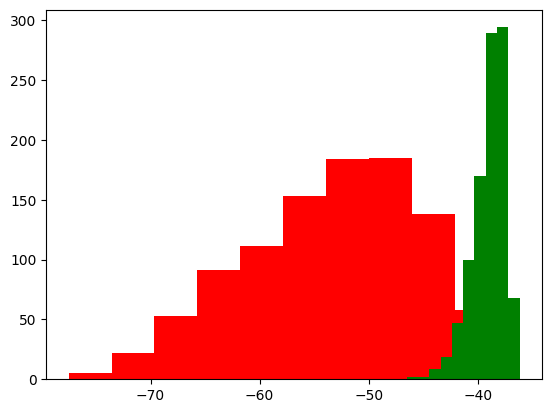

In [378]:
plt.hist(log_prob(p0,obs,obsunc,use,pmin,pmax),color='r')
plt.hist(log_prob(np.vstack(sampler.chain[:,-1:,:]),obs,obsunc,use,pmin,pmax),color='g')

In [380]:
opt=pd.DataFrame(sampler.chain[:,-1:,:].squeeze(),columns=parammat.columns)

In [383]:
opt.head()

,rlamdo,akapa,cpi,W,beto,lambda,mixed,qdirso2,qindso2,qbc,qoc,beta_f,mixed_carbon,qh2o_ch4
0,16.134249,0.459092,0.373549,1.450578,5.319626,0.887721,103.847275,-0.230271,-0.960966,0.132082,-0.070893,0.353872,82.710098,0.082246
1,6.027538,0.595358,0.487904,0.572674,6.602020,0.615960,103.735184,-0.283365,-0.568133,0.116018,-0.071009,0.420582,74.186882,0.096502
2,14.533054,0.795591,0.475064,0.793048,4.009378,0.594939,69.788033,-0.259206,-0.575978,0.168429,-0.075955,0.263063,96.901421,0.083235
3,9.060468,0.519543,0.354760,1.384690,2.940753,0.775858,88.326347,-0.388864,-0.720495,0.170281,-0.075564,0.440888,68.226051,0.080202
4,13.285375,0.401223,0.227995,2.300073,6.063512,1.057013,110.247993,-0.324173,-0.917830,0.103270,-0.085213,0.299161,90.966034,0.083409


In [384]:
store = pd.HDFStore('data/optparam.h5')
store['opt'] = opt
store.close()